In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

# 导入数据

In [2]:
columns = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]
df = pd.read_csv("/Users/renzhiqiang/Downloads/kddcup.data.gz", sep=",", names=columns, index_col=None)
df.shape

(4898431, 42)

# 进行数据预处理

In [3]:
df = df[df["service"]=="http"]
df = df.drop("service", axis=1)
if "service" in columns:
    columns.remove("service")

novelties =  df[df["label"]!="normal."]
novelties_normal = df[150000:154045]

novelties = pd.concat([novelties, novelties_normal])

normal = df[df["label"] == "normal."]

In [4]:
normal.shape, novelties.shape

((619046, 41), (8090, 41))

In [5]:
for col in normal.columns:
    if normal[col].dtype == "object":
        encoded = LabelEncoder()
        encoded.fit(normal[col])
        # 进行替换
        normal[col] = encoded.transform(normal[col])
        
for col in novelties.columns:
    if novelties[col].dtype == "object":
        encoded = LabelEncoder()
        encoded.fit(novelties[col])
        # 进行替换
        novelties[col] = encoded.transform(novelties[col])

/var/folders/97/nf61081d1l7135m5v32qhhxc0000gn/T/ipykernel_33878/62012241.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal[col] = encoded.transform(normal[col])


In [6]:
from sklearn.model_selection import train_test_split

for f in range(0, 10):
    normal = normal.iloc[np.random.permutation(len(normal))]

train_data = normal[100000:250000]
df_validate = normal[-50000:]

x_train, x_test, y_train, y_test = train_test_split(train_data, train_data["label"], test_size=0.2, random_state=42)

x_val, y_val = df_validate, df_validate["label"]

x_train = x_train.drop("label", axis=1)
x_val = x_val.drop("label", axis=1)
x_test = x_test.drop("label", axis=1)

# 进行模型训练

In [7]:
from sklearn.svm import OneClassSVM
ocsvm = OneClassSVM(kernel='rbf', gamma=0.00005,  nu=0.1)
ocsvm.fit(x_train)

OneClassSVM(gamma=5e-05, nu=0.1)

# 进行预测评估模型

In [10]:
preds = ocsvm.predict(x_val)

score = 0
for f in range(0, x_val.shape[0]):
    if preds[f] == 1:
        score = score+1

accuracy = score / x_val.shape[0]
print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 89.46%


In [16]:
from sklearn.metrics import roc_auc_score
x = novelties.drop("label", axis=1)

preds = ocsvm.predict(x)
matches = novelties["label"]==4
auc = roc_auc_score(preds, matches)

print("AUC: {:.2%}".format(auc))

AUC: 95.83%


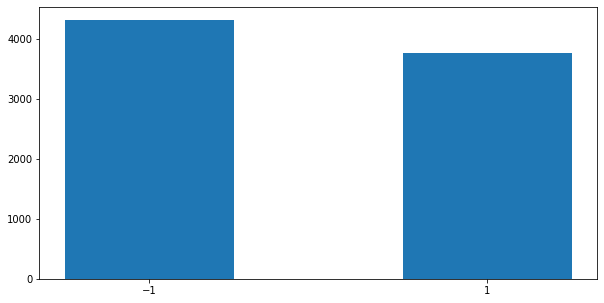

In [17]:
plt.figure(figsize=(10,5))
plt.hist(preds, bins=[-1.5, -0.5] + [0.5, 1.5], align='mid')
plt.xticks([-1, 1])
plt.show()